In [ ]:
! pip install nilearn

In [2]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# **Dataset A**

In [3]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=200) # this needs to be modified for  some tasks
print('%i regions found in this atlas' % (len(np.unique(nib.load(yeo.maps).get_fdata().ravel()))  - 1))
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # gives 1 for females and 0 for males

200 regions found in this atlas


### **Question 1**

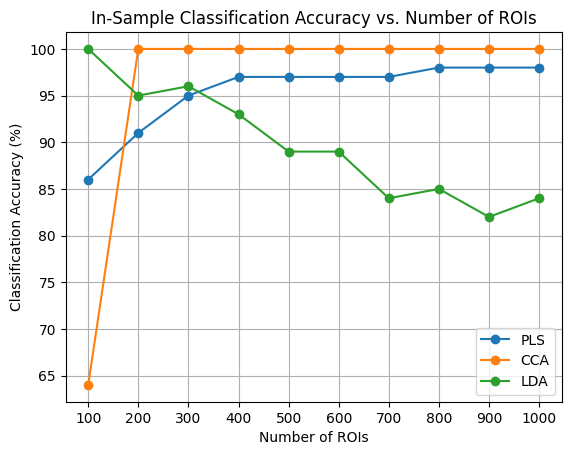

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load data
regions=list(range(100,1100,100)) # Number of ROIs to use
accuracies = {'PLS': [], 'CCA': [], 'LDA': []} # Dictionary to store accuracies

for region in regions: # Iterate through each region
    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=region) # Set n_rois to current region
    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = 2 * (np.array(brain_data.ext_vars.mf == 'F', dtype=int) - 0.5)  # Encode as +1/-1
    
    pls = PLSRegression(n_components=3) # Create PLS model
    pls.fit(input_variables, output_variable) # Fit the model
    pls_predictions = np.sign(pls.predict(input_variables).ravel()) # Make predictions
    accuracies['PLS'].append(accuracy_score(output_variable, pls_predictions)*100) # Calculate accuracy
    
    cca = CCA(n_components=1) #cca = CCA(n_components=2) # Create CCA model
    cca.fit(input_variables, output_variable) # Fit the model
    cca_predictions = np.sign(cca.predict(input_variables).ravel()) # Make predictions
    accuracies['CCA'].append(accuracy_score(output_variable, cca_predictions)*100) # Calculate accuracy
    
    lda = LinearDiscriminantAnalysis(n_components=1) # Create LDA model
    lda.fit(input_variables, output_variable) # Fit the model
    lda_predictions = np.sign(lda.predict(input_variables)) # Make predictions
    accuracies['LDA'].append(accuracy_score(output_variable, lda_predictions)*100) # Calculate accuracy

for model, acc in accuracies.items(): # For each model
    plt.plot(regions, acc, label=model, marker='o') # Plot the accuracy vs. number of ROIs
plt.xlabel('Number of ROIs')
plt.ylabel('Classification Accuracy (%)')
plt.xticks(regions)
plt.title('In-Sample Classification Accuracy vs. Number of ROIs')
plt.legend()
plt.grid(True)
plt.show()

### **Question 2**

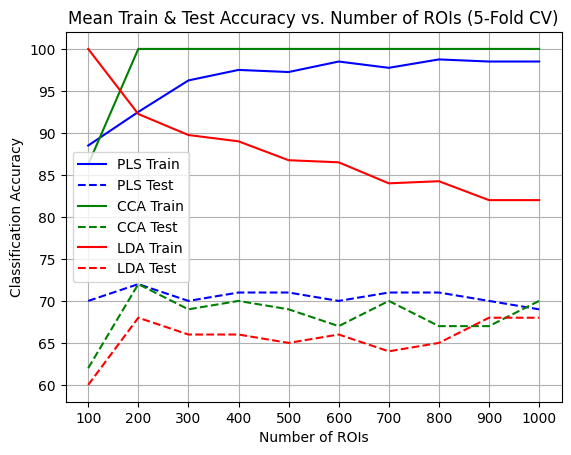

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load data
regions = range(100, 1100, 100)  # 100 to 1000 ROIs
# Dictionaries for storing accuracies
accuracies = {'PLS_train': [], 'PLS_test': [], 'CCA_train': [], 'CCA_test': [], 'LDA_train': [], 'LDA_test': []}
kf = KFold(n_splits=5, shuffle=True, random_state=42) # Number of folds for cross-validation

for region in regions: # Iterate through each region
    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=region) # Set n_rois to current region
    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = 2 * (np.array(brain_data.ext_vars.mf == 'F', dtype=int) - 0.5)  # Encode as +1/-1
    
    train_accuracies = {'PLS': [], 'CCA': [], 'LDA': []} # Dict for train accuracies
    test_accuracies = {'PLS': [], 'CCA': [], 'LDA': []} # Dict for test accuracies
    
    # Perform K-Fold cross-validation
    for train_index, test_index in kf.split(input_variables):
        X_train, X_test = input_variables[train_index], input_variables[test_index]
        y_train, y_test = output_variable[train_index], output_variable[test_index]
        
        pls = PLSRegression(n_components=3) # Create PLS model
        pls.fit(X_train, y_train) # Fit model on training data
        pls_train_pred = np.sign(pls.predict(X_train).ravel()) # Predict on train data
        pls_test_pred = np.sign(pls.predict(X_test).ravel()) # Predict on test data
        train_accuracies['PLS'].append(accuracy_score(y_train, pls_train_pred)*100) # Calculate train accuracy
        test_accuracies['PLS'].append(accuracy_score(y_test, pls_test_pred)*100) # Calculate test accuracy

        cca = CCA(n_components=1) #cca = CCA(n_components=2) # Create CCA model
        cca.fit(X_train, y_train[:, np.newaxis]) # Fit model on training data
        cca_train_pred = np.sign(cca.predict(X_train).ravel()) # Predict on train data
        cca_test_pred = np.sign(cca.predict(X_test).ravel()) # Predict on test data
        train_accuracies['CCA'].append(accuracy_score(y_train, cca_train_pred)*100) # Calculate train accuracy
        test_accuracies['CCA'].append(accuracy_score(y_test, cca_test_pred)*100) # Calculate test accuracy

        lda = LinearDiscriminantAnalysis() # Create LDA model
        lda.fit(X_train, y_train) # Fit model on training data
        lda_train_pred = np.sign(lda.predict(X_train)) # Predict on train data
        lda_test_pred = np.sign(lda.predict(X_test)) # Predict on test data
        train_accuracies['LDA'].append(accuracy_score(y_train, lda_train_pred)*100) # Calculate train accuracy
        test_accuracies['LDA'].append(accuracy_score(y_test, lda_test_pred)*100) # Calculate test accuracy
    
    for model in ['PLS', 'CCA', 'LDA']: # For each model
        accuracies[f'{model}_train'].append(np.mean(train_accuracies[model])) # Calculate mean train accuracy
        accuracies[f'{model}_test'].append(np.mean(test_accuracies[model])) # Calculate mean test accuracy

# Plot results
models, colors = ['PLS', 'CCA', 'LDA'], ['blue', 'green', 'red'] # Models and colors for plotting
for i, model in enumerate(models): # For each model, plot train and test accuracies
    plt.plot(regions, accuracies[f'{model}_train'], label=f'{model} Train', linestyle='-', color=colors[i])
    plt.plot(regions, accuracies[f'{model}_test'], label=f'{model} Test', linestyle='--', color=colors[i])
plt.xlabel('Number of ROIs')
plt.ylabel('Classification Accuracy')
plt.xticks(regions)
plt.title('Mean Train & Test Accuracy vs. Number of ROIs (5-Fold CV)')
plt.legend()
plt.grid(True)
plt.show()

### **Question 3**

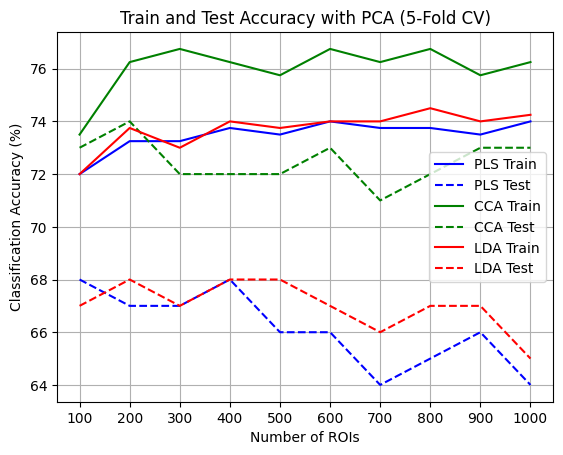

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load data
regions = range(100, 1100, 100)  # 100 to 1000 ROIs
# Results storage
accuracies = {'PLS_train': [], 'PLS_test': [], 'CCA_train': [], 'CCA_test': [], 'LDA_train': [], 'LDA_test': []}
kf = KFold(n_splits=5) # Kfold cross-validation

for region in regions: # Iterate through each region
    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=region) # Set n_rois to current region
    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = 2 * (np.array(brain_data.ext_vars.mf == 'F', dtype=int) - 0.5)  # Encode as +1/-1
    
    train_accuracies = {'PLS': [], 'CCA': [], 'LDA': []} # Train accuracies
    test_accuracies = {'PLS': [], 'CCA': [], 'LDA': []} # Test accuracies
    
    for train_index, test_index in kf.split(input_variables): # Iterate through each fold
        X_train, X_test = input_variables[train_index], input_variables[test_index] # Split input data
        y_train, y_test = output_variable[train_index], output_variable[test_index] # Split output data

        pca = PCA(n_components=3) # Create PCA model 
        X_train_pca = pca.fit_transform(X_train) # Fit & transform training data
        X_test_pca = pca.transform(X_test) # Transform test data

        pls = PLSRegression(n_components=3) # Create PLS model
        pls.fit(X_train_pca, y_train) # Fit model on training data
        pls_train_pred = np.sign(pls.predict(X_train_pca).ravel()) # Predict on train data
        pls_test_pred = np.sign(pls.predict(X_test_pca).ravel()) # Predict on test data
        train_accuracies['PLS'].append(accuracy_score(y_train, pls_train_pred)*100) # Calculate train accuracy
        test_accuracies['PLS'].append(accuracy_score(y_test, pls_test_pred)*100) # Calculate test accuracy

        cca = CCA(n_components=1) #cca = CCA(n_components=2) # Create CCA model
        cca.fit(X_train_pca, y_train[:, np.newaxis]) # Fit model on training data
        cca_train_pred = np.sign(cca.predict(X_train_pca).ravel()) # Predict on train data
        cca_test_pred = np.sign(cca.predict(X_test_pca).ravel()) # Predict on test data
        train_accuracies['CCA'].append(accuracy_score(y_train, cca_train_pred)*100) # Calculate train accuracy
        test_accuracies['CCA'].append(accuracy_score(y_test, cca_test_pred)*100) # Calculate test accuracy

        lda = LinearDiscriminantAnalysis() # Create LDA model
        lda.fit(X_train_pca, y_train) # Fit model on training data
        lda_train_pred = np.sign(lda.predict(X_train_pca)) # Predict on train data
        lda_test_pred = np.sign(lda.predict(X_test_pca)) # Predict on test data
        train_accuracies['LDA'].append(accuracy_score(y_train, lda_train_pred)*100)
        test_accuracies['LDA'].append(accuracy_score(y_test, lda_test_pred)*100)
    
    for model in ['PLS', 'CCA', 'LDA']: # For each model
        accuracies[f'{model}_train'].append(np.mean(train_accuracies[model])) # Calculate mean train accuracy
        accuracies[f'{model}_test'].append(np.mean(test_accuracies[model])) # Calculate mean test accuracy

# Plot results
models, colors = ['PLS', 'CCA', 'LDA'], ['blue', 'green', 'red'] # Models and colors for plotting
for i, model in enumerate(models): # Iterate through each model, plot train and test accuracies
    plt.plot(regions, accuracies[f'{model}_train'], label=f'{model} Train', linestyle='-', color=colors[i])
    plt.plot(regions, accuracies[f'{model}_test'], label=f'{model} Test', linestyle='--', color=colors[i])
plt.xlabel('Number of ROIs')
plt.ylabel('Classification Accuracy (%)')
plt.xticks(regions)
plt.title('Train and Test Accuracy with PCA (5-Fold CV)')
plt.legend()
plt.grid(True)
plt.show() 

### **Question 4**

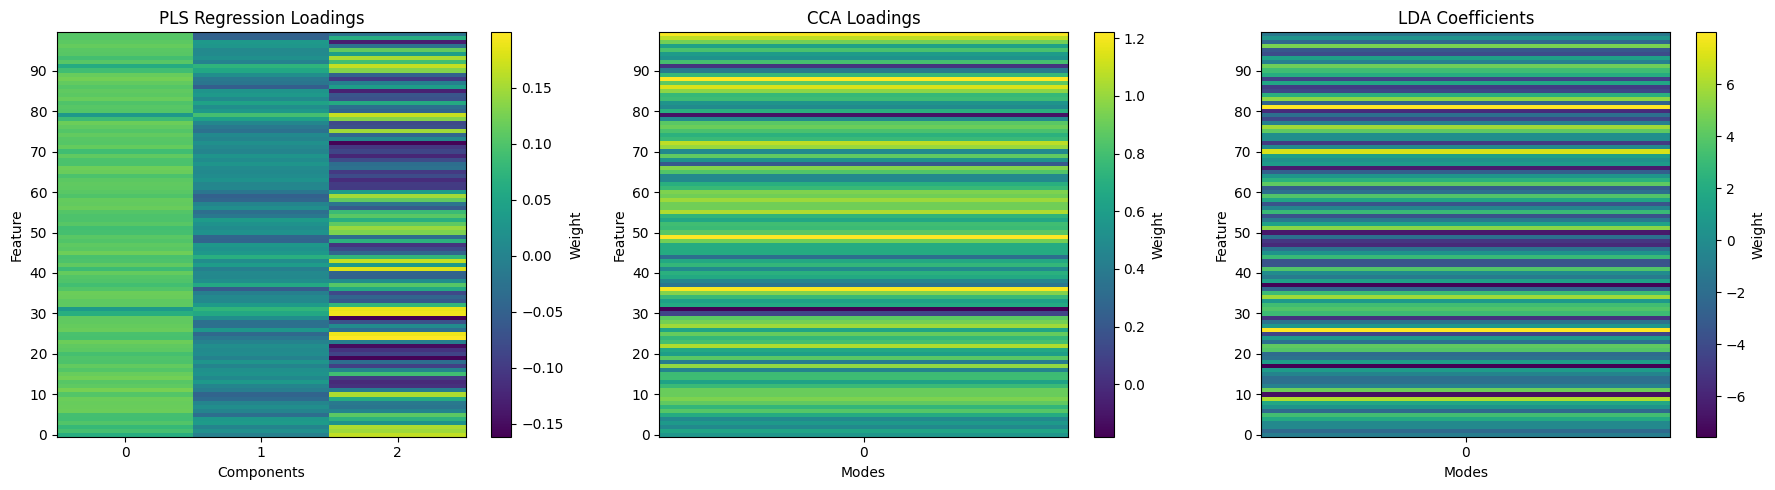

In [33]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100) # this needs to be modified for  some tasks
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = 2 * (np.array(brain_data.ext_vars.mf == 'F', dtype=int) - 0.5)  # Encode as +1/-1

kf = KFold(n_splits=5)#, shuffle=True, random_state=42) # Number of folds for cross-validation
pls_loadings, cca_loadings, lda_coefs = [], [], [] # Lists for model parameters

for train_index, test_index in kf.split(input_variables): # Iterate through each fold
    X_train, X_test = input_variables[train_index], input_variables[test_index] # Split input data
    y_train, y_test = output_variable[train_index], output_variable[test_index] # Split output data

    pls = PLSRegression(n_components=3) # Create PLS model
    pls.fit(X_train, y_train) # Fit model on training data
    pls_loadings.append(pls.x_loadings_) # Store loadings

    cca = CCA(n_components=1) #cca = CCA(n_components=2) # Create CCA model
    cca.fit(X_train, y_train[:, np.newaxis]) # Fit model on training data
    cca_loadings.append(cca.x_loadings_) # Store loadings

    lda = LinearDiscriminantAnalysis() # Create LDA model
    lda.fit(X_train, y_train) # Fit model on training data
    lda_coefs.append(lda.coef_) # Store coefficients

# Average the model parameters across the 5 folds
pls_mean_loadings = np.mean(pls_loadings, axis=0)
cca_mean_loadings = np.mean(cca_loadings, axis=0)
lda_mean_coefs = np.mean(lda_coefs, axis=0)
lda_mean_coefs = lda_mean_coefs.ravel()[:, np.newaxis]  # Prepare data for plot

# Plot heatmaps
plt.figure(figsize=(18, 5)) # Set figure size
loadings = [pls_mean_loadings, cca_mean_loadings, lda_mean_coefs] # List of models
for i in range(3): # For each model
    plt.subplot(1, 3, i+1)
    plt.imshow(loadings[i], aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Weight')
    plt.title(['PLS Regression Loadings', 'CCA Loadings', 'LDA Coefficients'][i])
    plt.xlabel(['Components', 'Modes', 'Modes'][i])
    plt.ylabel('Feature')
    plt.yticks(range(0, 100, 10))
    plt.xticks(range(loadings[i].shape[1]))
plt.tight_layout()
plt.show()


### **Question 5**

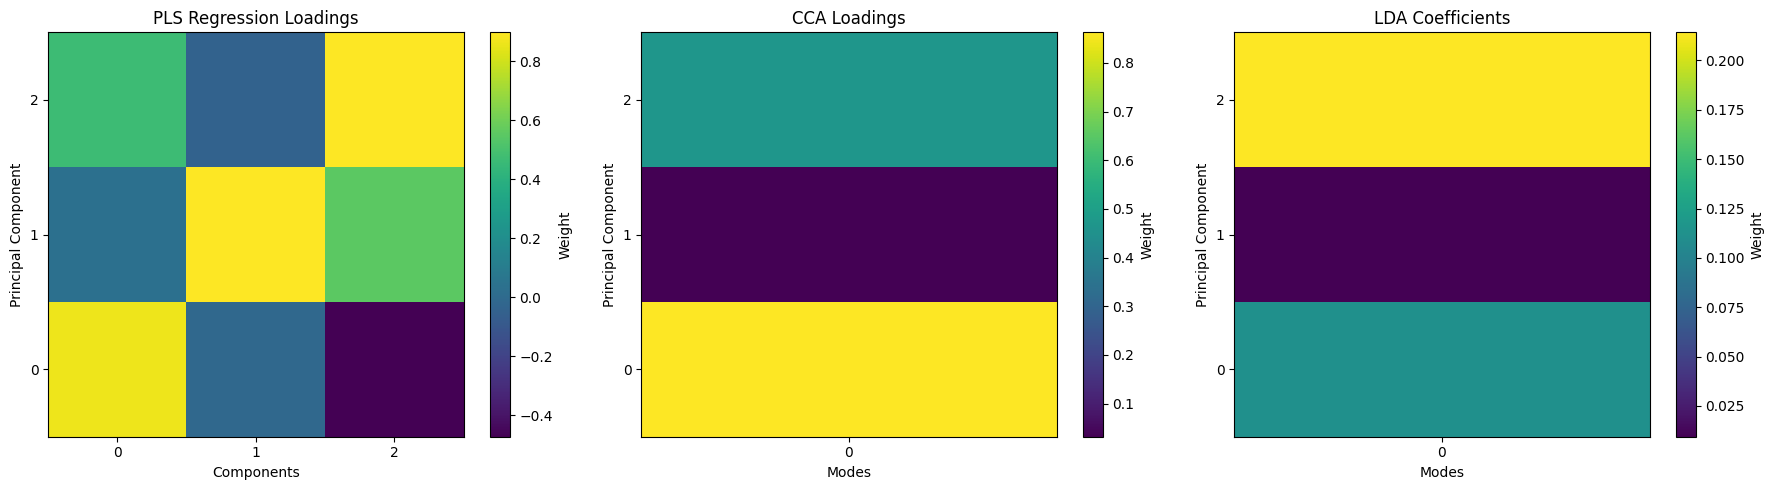

In [31]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100) 
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = 2 * (np.array(brain_data.ext_vars.mf == 'F', dtype=int) - 0.5)  # Encode as +1/-1

kf = KFold(n_splits=5)#, shuffle=True, random_state=42) # Number of folds for cross-validation
pls_loadings, cca_loadings, lda_coefs = [], [], [] # Lists for model parameters

for train_index, test_index in kf.split(input_variables): # Iterate through each fold
    X_train, X_test = input_variables[train_index], input_variables[test_index] # Split input data
    y_train, y_test = output_variable[train_index], output_variable[test_index] # Split output data

    pca = PCA(n_components=3) # Create PCA model
    X_train_pca = pca.fit_transform(X_train) # Fit & transform training data
    X_test_pca = pca.transform(X_test) # Transform test data

    pls = PLSRegression(n_components=3) # Create PLS model
    pls.fit(X_train_pca, y_train) # Fit model on training data
    pls_loadings.append(pls.x_loadings_) # Store loadings

    cca = CCA(n_components=1) # cca = CCA(n_components=2) # Create CCA model
    cca.fit(X_train_pca, y_train[:, np.newaxis]) # Fit model on training data
    cca_loadings.append(cca.x_loadings_) # Store loadings

    lda = LinearDiscriminantAnalysis(n_components=1) # Create LDA model
    lda.fit(X_train_pca, y_train) # Fit model on training data
    lda_coefs.append(lda.coef_) # Store coefficients

# Average the model parameters
pls_mean_loadings = np.mean(pls_loadings, axis=0)
cca_mean_loadings = np.mean(cca_loadings, axis=0) 
lda_mean_coefs = np.mean(lda_coefs, axis=0) 
lda_mean_coefs = lda_mean_coefs.ravel()[:, np.newaxis] # Prepare data for plotting

# Plot heatmaps
plt.figure(figsize=(18, 5)) # Set figure size
loadings=[pls_mean_loadings, cca_mean_loadings, lda_mean_coefs] # List of params
for i in range(3): # For each model
    plt.subplot(1, 3, i+1)
    plt.imshow(loadings[i], aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Weight')
    plt.title(['PLS Regression Loadings', 'CCA Loadings', 'LDA Coefficients'][i])
    plt.xlabel(['Components', 'Modes', 'Modes'][i])
    plt.yticks(range(3))
    plt.xticks(range(loadings[i].shape[1]))
    plt.ylabel('Principal Component')
plt.tight_layout()
plt.show()

# **Dataset B**

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 42) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_fdata().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

### **Question 6**

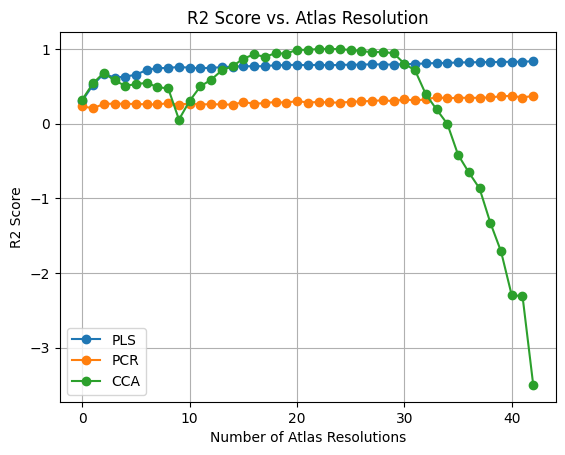

In [34]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlases=range(43) # Atlas resolutions to use
r2_scores = {'PLS': [], 'PCR': [], 'CCA': []} # Dictionary to store r2_scores

for atlas in atlases: # Iterate through each region
    atlas_nii = index_img(crad['scorr_mean'], atlas) # set to current atlas resolution
    masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] 
    
    pls = PLSRegression(n_components=3) # Create PLS model
    pls.fit(input_variables, output_variable) # Fit the model
    pls_predictions = pls.predict(input_variables).ravel() # Make predictions
    r2_scores['PLS'].append(r2_score(output_variable, pls_predictions)) # Calculate r2

    pcr = make_pipeline(StandardScaler(), PCA(n_components=3), LinearRegression()) # Create PCR model
    pcr.fit(input_variables, output_variable) # Fit the model
    pcr_predictions = pcr.predict(input_variables).ravel() # Make predictions
    r2_scores['PCR'].append(r2_score(output_variable, pcr_predictions)) # Calculate r2

    cca = CCA(n_components=1) #cca = CCA(n_components=2) # Create CCA model
    cca.fit(input_variables, output_variable) # Fit the model
    cca_predictions = cca.predict(input_variables).ravel() # Make predictions
    r2_scores['CCA'].append(r2_score(output_variable, cca_predictions)) # Calculate r2

for model, r2 in r2_scores.items(): # For each model
    plt.plot(atlases, r2, label=model, marker='o') # Plot the accuracy vs. number of ROIs
plt.xlabel('Number of Atlas Resolutions')
plt.ylabel('R2 Score')
plt.title('R2 Score vs. Atlas Resolution')
plt.legend()
plt.grid(True)
plt.show()

### **Question 7**

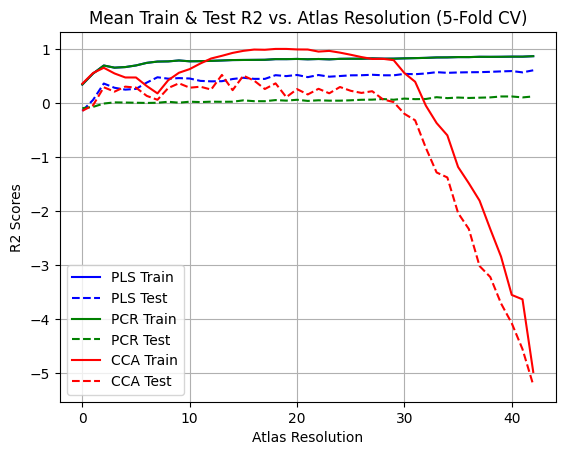

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlases=range(43) # 43 atlases
# Storing R2 scores for each model's train and test data
r2_scores = {'PLS_train': [], 'PLS_test': [], 'PCR_train': [], 'PCR_test': [], 'CCA_train': [], 'CCA_test': []}
kf = KFold(n_splits=5, shuffle=True, random_state=42) # Number of folds for cross-validation

for atlas in atlases: # Iterate through each region
    atlas_nii = index_img(crad['scorr_mean'], atlas)
    masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] 
    
    train_r2 = {'PLS': [], 'PCR': [], 'CCA': []} # Dict for train r2 scores
    test_r2 = {'PLS': [], 'PCR': [], 'CCA': []} # Dict for test r2 scores
    
    for train_index, test_index in kf.split(input_variables): # Iterate through each fold
        X_train, X_test = input_variables[train_index], input_variables[test_index] # Split input data
        y_train, y_test = output_variable[train_index], output_variable[test_index] # Split output data
        
        pls = PLSRegression(n_components=3) # Create PLS model
        pls.fit(X_train, y_train) # Fit the model
        pls_train_pred = pls.predict(X_train).ravel() # Predict on train data
        pls_test_pred = pls.predict(X_test).ravel() # Predict on test data
        train_r2['PLS'].append(r2_score(y_train, pls_train_pred)) # Calculate train r2
        test_r2['PLS'].append(r2_score(y_test, pls_test_pred)) # Calculate test r2

        pcr = make_pipeline(StandardScaler(), PCA(n_components=3), LinearRegression()) # Create PCR model
        pcr.fit(X_train, y_train) # Fit the model
        pcr_train_pred = pcr.predict(X_train).ravel() # Predict on train data
        pcr_test_pred = pcr.predict(X_test).ravel() # Predict on test data
        train_r2['PCR'].append(r2_score(y_train, pls_train_pred)) # Calculate r2
        test_r2['PCR'].append(r2_score(y_test, pcr_test_pred)) # Calculate r2

        cca = CCA(n_components=1) #cca = CCA(n_components=2) # Create CCA model
        cca.fit(X_train, y_train) # Fit the model
        cca_train_pred = cca.predict(X_train).ravel() # Predict on train data
        cca_test_pred = cca.predict(X_test).ravel() # Predict on test data
        train_r2['CCA'].append(r2_score(y_train, cca_train_pred)) # Calculate r2
        test_r2['CCA'].append(r2_score(y_test, cca_test_pred)) # Calculate r2

    for model in ['PLS', 'PCR', 'CCA']: # For each model
        r2_scores[f'{model}_train'].append(np.mean(train_r2[model])) # Calculate mean train r2
        r2_scores[f'{model}_test'].append(np.mean(test_r2[model])) # Calculate mean test r2
        
# Plot results
models, colors = ['PLS', 'PCR', 'CCA'], ['blue', 'green', 'red'] # Models and colors for plotting
for i, model in enumerate(models): # For each model, plot train and test accuracies
    plt.plot(atlases, r2_scores[f'{model}_train'], label=f'{model} Train', linestyle='-', color=colors[i])
    plt.plot(atlases, r2_scores[f'{model}_test'], label=f'{model} Test', linestyle='--', color=colors[i])
plt.xlabel('Atlas Resolution')
plt.ylabel('R2 Scores')
plt.title('Mean Train & Test R2 vs. Atlas Resolution (5-Fold CV)')
plt.legend()
plt.grid(True)
plt.show()

### **Question 8**

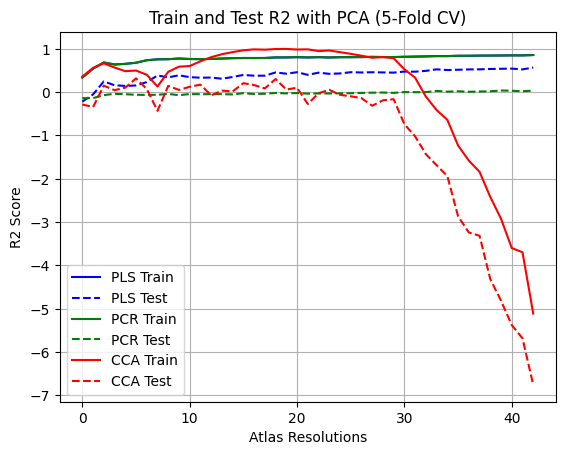

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlases=range(43) # 43 atlases
# Dictionaries for storing accuracies
r2_scores = {'PLS_train': [], 'PLS_test': [], 'PCR_train': [], 'PCR_test': [], 'CCA_train': [], 'CCA_test': []}
kf = KFold(n_splits=5)#, shuffle=True, random_state=42) # Number of folds for cross-validation

for atlas in atlases: # Iterate through each region
    atlas_nii = index_img(crad['scorr_mean'], atlas) # this needs to be modified for some tasks
    masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] 
    
    train_r2 = {'PLS': [], 'PCR': [], 'CCA': []} # Dict for train r2
    test_r2 = {'PLS': [], 'PCR': [], 'CCA': []} # Dict for test r2
    
    for train_index, test_index in kf.split(input_variables): # Iterate through each fold
        X_train, X_test = input_variables[train_index], input_variables[test_index] # Split input data
        y_train, y_test = output_variable[train_index], output_variable[test_index] # Split output data
        
        pca = PCA(n_components=3) # Create PCA model 
        X_train_pca = pca.fit_transform(X_train) # Fit & transform training data
        X_test_pca = pca.transform(X_test) # Transform test data

        pls = PLSRegression(n_components=3) # Create PLS model
        pls.fit(X_train, y_train) # Fit the model
        pls_train_pred = pls.predict(X_train).ravel() # Predict on train data
        pls_test_pred = pls.predict(X_test).ravel() # Predict on test data
        train_r2['PLS'].append(r2_score(y_train, pls_train_pred)) # Calculate train r2
        test_r2['PLS'].append(r2_score(y_test, pls_test_pred)) # Calculate test r2

        pcr = make_pipeline(StandardScaler(), PCA(n_components=3), LinearRegression()) # Create PCR model
        pcr.fit(X_train, y_train) # Fit the model
        pcr_train_pred = pcr.predict(X_train).ravel() # Predict on train data
        pcr_test_pred = pcr.predict(X_test).ravel() # Predict on test data
        train_r2['PCR'].append(r2_score(y_train, pls_train_pred)) # Calculate r2
        test_r2['PCR'].append(r2_score(y_test, pcr_test_pred)) # Calculate r2

        cca = CCA(n_components=1) #cca = CCA(n_components=2) # Create CCA model
        cca.fit(X_train, y_train) # Fit the model
        cca_train_pred = cca.predict(X_train).ravel() # Predict on train data
        cca_test_pred = cca.predict(X_test).ravel() # Predict on test data
        train_r2['CCA'].append(r2_score(y_train, cca_train_pred)) # Calculate r2
        test_r2['CCA'].append(r2_score(y_test, cca_test_pred)) # Calculate r2

    # Store mean accuracies for the current n_rois
    for model in ['PLS', 'PCR', 'CCA']: # For each model
        r2_scores[f'{model}_train'].append(np.mean(train_r2[model])) # Calculate mean train r2
        r2_scores[f'{model}_test'].append(np.mean(test_r2[model])) # Calculate mean test r2

# Plot results
models, colors = ['PLS', 'PCR', 'CCA'], ['blue', 'green', 'red'] # Models and colors for plotting
for i, model in enumerate(models): # Iterate through each model, plot train and test accuracies
    plt.plot(atlases, r2_scores[f'{model}_train'], label=f'{model} Train', linestyle='-', color=colors[i])
    plt.plot(atlases, r2_scores[f'{model}_test'], label=f'{model} Test', linestyle='--', color=colors[i])
plt.xlabel('Atlas Resolutions')
plt.ylabel('R2 Score')
plt.title('Train and Test R2 with PCA (5-Fold CV)')
plt.legend()
plt.grid(True)
plt.show()

### **Question 9**

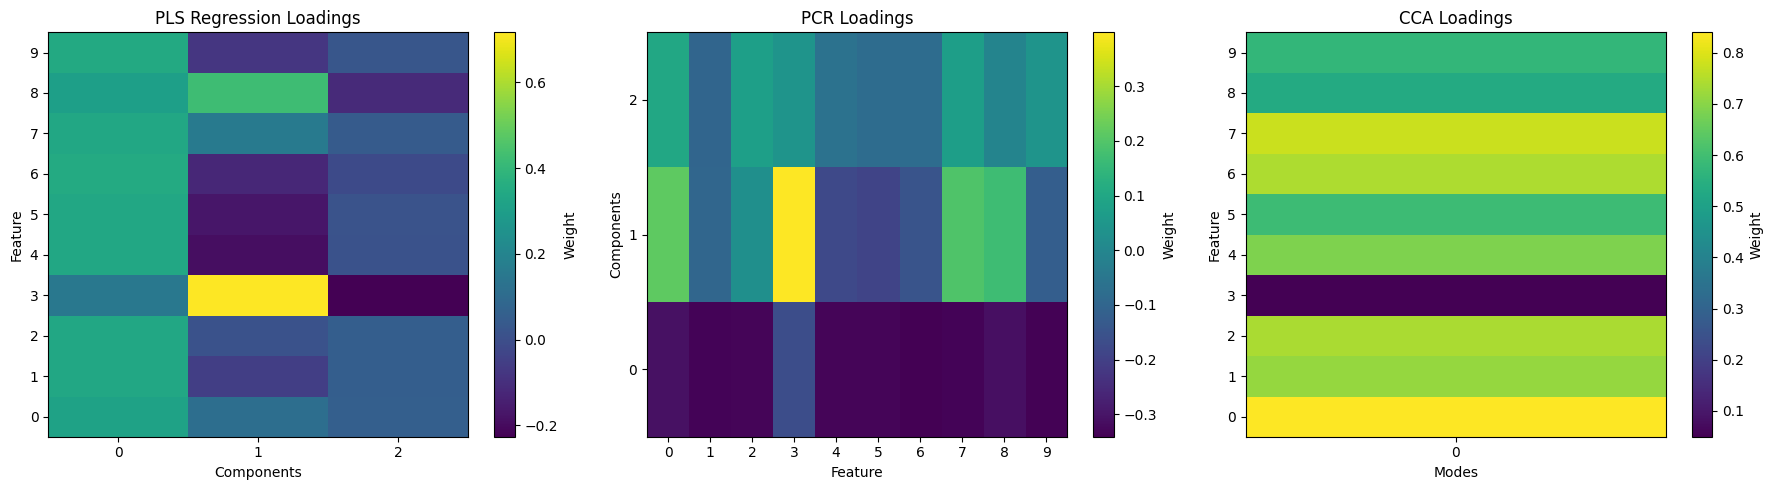

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0)
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0]

kf = KFold(n_splits=5)#, shuffle=True, random_state=42) # Number of folds for cross-validation
pls_loadings, pcr_loadings, cca_loadings = [], [], [] # Lists for model parameters

for train_index, test_index in kf.split(input_variables): # Iterate through each fold
    X_train, X_test = input_variables[train_index], input_variables[test_index] # Split input data
    y_train, y_test = output_variable[train_index], output_variable[test_index] # Split output data

    pls = PLSRegression(n_components=3) # Create PLS model
    pls.fit(X_train, y_train) # Fit model on training data
    pls_loadings.append(pls.x_loadings_) # Store loadings

    pcr = make_pipeline(StandardScaler(), PCA(n_components=3), LinearRegression()) # Create PCR model
    pcr.fit(X_train, y_train) # Fit model on training data
    pcr_loadings.append(pcr.named_steps['pca'].components_) # Store loadings

    cca = CCA(n_components=1) #cca = CCA(n_components=2) # Create CCA model
    cca.fit(X_train, y_train[:, np.newaxis]) # Fit model on training data
    cca_loadings.append(cca.x_loadings_) # Store loadings

# Average the model parameters across the 5 folds
pls_mean_loadings = np.mean(pls_loadings, axis=0)
pcr_mean_loadings = np.mean(pcr_loadings, axis=0)
cca_mean_loadings = np.mean(cca_loadings, axis=0)

# Plot heatmaps
plt.figure(figsize=(18, 5)) # Set figure size
loadings = [pls_mean_loadings, pcr_mean_loadings, cca_mean_loadings] # List of models
for i in range(3): # For each model
    plt.subplot(1, 3, i+1)
    plt.imshow(loadings[i], aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Weight')
    plt.title(['PLS Regression Loadings', 'PCR Loadings', 'CCA Loadings'][i])
    plt.xlabel(['Components', 'Feature', 'Modes'][i])
    plt.ylabel(['Feature', 'Components', 'Feature'][i])
    plt.yticks([range(10), range(3), range(10)][i])
    plt.xticks(range(loadings[i].shape[1]))
plt.tight_layout()
plt.show()

### **Question 10**

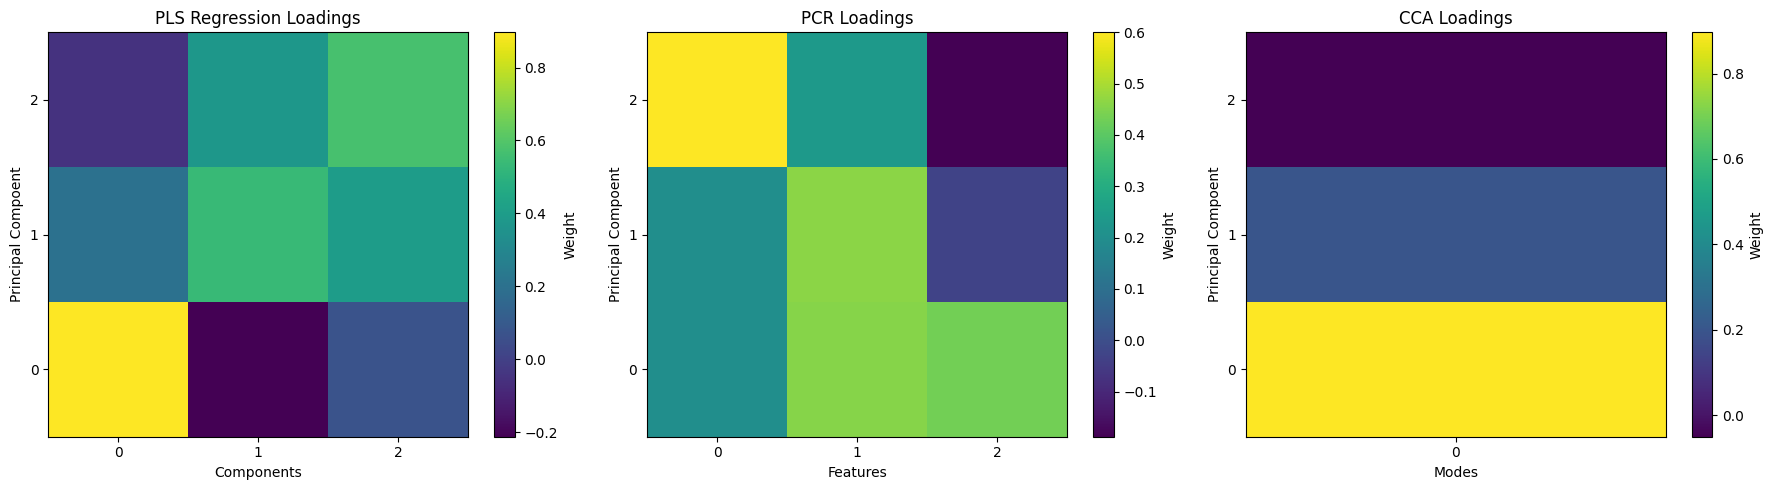

In [ ]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 0)
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0]

kf = KFold(n_splits=5)#, shuffle=True, random_state=42) # Number of folds for cross-validation
pls_loadings, pcr_loadings, cca_loadings = [], [], [] # Lists for model parameters

for train_index, test_index in kf.split(input_variables): # Iterate through each fold
    X_train, X_test = input_variables[train_index], input_variables[test_index] # Split input data
    y_train, y_test = output_variable[train_index], output_variable[test_index] # Split output data

    pca = PCA(n_components=3) # Create PCA model
    X_train_pca = pca.fit_transform(X_train) # Fit & transform training data
    X_test_pca = pca.transform(X_test) # Transform test data

    pls = PLSRegression(n_components=3) # Create PLS model
    pls.fit(X_train_pca, y_train) # Fit model on training data
    pls_loadings.append(pls.x_loadings_) # Store loadings

    pcr = make_pipeline(StandardScaler(), PCA(n_components=3), LinearRegression()) # Create PCR model
    pcr.fit(X_train_pca, y_train) # Fit model on training data
    pcr_loadings.append(pcr.named_steps['pca'].components_) # Store loadings

    cca = CCA(n_components=1) # cca = CCA(n_components=2) # Create CCA model
    cca.fit(X_train_pca, y_train[:, np.newaxis]) # Fit model on training data
    cca_loadings.append(cca.x_loadings_) # Store loadings

# Average the model parameters
pls_mean_loadings = np.mean(pls_loadings, axis=0)
pcr_mean_loadings = np.mean(pcr_loadings, axis=0)
cca_mean_loadings = np.mean(cca_loadings, axis=0) 

# Plot heatmaps
plt.figure(figsize=(18, 5)) # Set figure size for heatmaps
loadings=[pls_mean_loadings, pcr_mean_loadings, cca_mean_loadings] # List of params
for i in range(3): # For each model
    plt.subplot(1, 3, i+1)
    plt.imshow(loadings[i], aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Weight')
    plt.title(['PLS Regression Loadings', 'PCR Loadings','CCA Loadings'][i])
    plt.xlabel(['Components', 'Features', 'Modes'][i])
    plt.ylabel('Principal Compoent')
    plt.yticks(range(3))
    plt.xticks(range(loadings[i].shape[1]))
plt.tight_layout()
plt.show()